
# Binance Minute OHLCV — Quick Examine Notebook

This notebook **uses the helper functions from** `fin_rl.data.io.candle_io` (the same module you just ran)  
to quickly examine minute-level Binance OHLCV data, **without resampling**.

What you'll get:
- Load latest CSV per symbol with unified schema
- Print schema overview, sample head/tail, time range
- Basic quality checks (duplicates, NaN, negatives, missing bars)
- Enrich features (returns, log-returns, dollar volume, rolling vol)
- Basic stats table across symbols
- Visuals: Close+MA, Volume, Log-return histogram, and cross-symbol correlation heatmap

> **Note**: This notebook assumes your module `fin_rl.data.io.candle_io` exposes the same public functions
> you used via CLI: `load_symbol_csv`, `print_overview`, `quality_checks`, `enrich_features`, `basic_stats`,
> `plot_price_with_ma`, `plot_volume`, `plot_logret_hist`, `plot_corr_heatmap`.


In [2]:

# ==== CONFIG ====
DATA_DIR = "../../work/data/binance/spot/1m"   # change if needed
CANDLE_LEVEL = "1m"
SYMBOLS = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT"]
SAVE_PLOTS = True            # set False to only display on screen
OUT_DIR = "./_out"           # used by your plotting functions if they save


In [1]:

# ==== IMPORTS ====
import os, sys
import pandas as pd
import numpy as np

# If your project root isn't in sys.path, add it here (edit as needed)
# sys.path.append("/path/to/your/project/root")

# Import the module you ran earlier
from fin_rl.data.io import candle_io as cio

# If you're actively editing the module and want latest changes without restarting kernel:
from importlib import reload
reload(cio)

print("Loaded helpers from:", cio.__file__)


Loaded helpers from: /home/kylh/phd/tw_fin_rl/fin_rl/data/io/candle_io.py


## 1) Load latest CSV for each symbol

In [3]:

store = {}
print(f"[INFO] Loading {len(SYMBOLS)} symbols from {DATA_DIR} | candle={CANDLE_LEVEL}")
for sym in SYMBOLS:
    df, fp = cio.load_symbol_csv(sym, data_dir=DATA_DIR, candle_level=CANDLE_LEVEL)
    store[sym] = {"df": df, "path": fp}
    print(f"[OK] {sym}: {len(df):,} rows | file={os.path.basename(fp)}")


[INFO] Loading 4 symbols from ../../work/data/binance/spot/1m | candle=1m
[OK] BTCUSDT: 3,507,322 rows | file=BTCUSDT_1m_2019-01-01_2025-09-04.csv
[OK] ETHUSDT: 3,507,344 rows | file=ETHUSDT_1m_2019-01-01_2025-09-04.csv
[OK] BNBUSDT: 3,507,365 rows | file=BNBUSDT_1m_2019-01-01_2025-09-04.csv
[OK] SOLUSDT: 2,662,968 rows | file=SOLUSDT_1m_2019-01-01_2025-09-04.csv


## 2) Overview & Quality checks

In [4]:

for sym, obj in store.items():
    df = obj["df"]
    cio.print_overview(df, sym)
    cio.quality_checks(df, sym, expected_freq="1min")



== BTCUSDT | Overview ==
Rows: 3,507,322
Dtypes:
open_time        datetime64[ns, UTC]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
close_time                     int64
QuoteVolume                  float64
Trades                         int64
TakerBuyBase                 float64
TakerBuyQuote                float64
ignore                         int64
dtype: object

Head:
                  open_time     Open     High      Low    Close     Volume  \
0 2019-01-01 00:00:00+00:00  3701.23  3703.72  3701.09  3702.46  17.100110   
1 2019-01-01 00:01:00+00:00  3702.44  3702.63  3695.66  3697.04  23.700604   
2 2019-01-01 00:02:00+00:00  3699.42  3702.04  3696.08  3698.14  14.488615   

      close_time   QuoteVolume  Trades  TakerBuyBase  TakerBuyQuote  ignore  
0  1546300859999  63299.707312     180      5.746515   21275.695014       0  
1  1546300919999

## 3) Enrich features (returns, log-returns, dollar volume, rolling vol)

In [5]:

for sym, obj in store.items():
    df_en = cio.enrich_features(obj["df"])
    store[sym]["df_en"] = df_en
    # optional: taker metrics
    if "TakerBuyBase" in df_en.columns and "Volume" in df_en.columns:
        df_en["TakerBuyRatio"] = df_en["TakerBuyBase"] / df_en["Volume"]
        df_en["TakerBuyRatio"] = df_en["TakerBuyRatio"].clip(0, 1)


## 4) Basic stats across symbols

In [6]:

rows = []
for sym, obj in store.items():
    s = cio.basic_stats(obj["df_en"] if "df_en" in obj else obj["df"])
    s["symbol"] = sym
    rows.append(s)

summary = pd.DataFrame(rows).set_index("symbol") if rows else pd.DataFrame()
# Pretty-print datetime
if not summary.empty:
    for col in ["start_ts", "end_ts"]:
        if col in summary.columns:
            summary[col] = pd.to_datetime(summary[col], errors="coerce", utc=True)
summary


,rows,start_ts,end_ts,close_mean,close_std,volume_mean,trades_mean
symbol,,,,,,,
BTCUSDT,3507322.0,2019-01-01 00:00:00+00:00,2025-09-04 11:52:00+00:00,38509.015149,29866.725883,49.885524,1460.428558
ETHUSDT,3507344.0,2019-01-01 00:00:00+00:00,2025-09-04 12:14:00+00:00,1793.578389,1253.669453,420.871047,787.516683
BNBUSDT,3507365.0,2019-01-01 00:00:00+00:00,2025-09-04 12:35:00+00:00,301.027184,235.392947,1045.125183,323.496416
SOLUSDT,2662968.0,2020-08-11 06:00:00+00:00,2025-09-04 12:51:00+00:00,86.362662,71.776040,3101.762146,576.178450


## 5) Visuals (no resampling)

/home/kylh/phd/tw_fin_rl/fin_rl/data/io/candle_io.py:241: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kylh/phd/tw_fin_rl/fin_rl/data/io/candle_io.py:244: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(OUT_DIR, f"{sym}_price_ma.png"), dpi=150)
/home/kylh/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


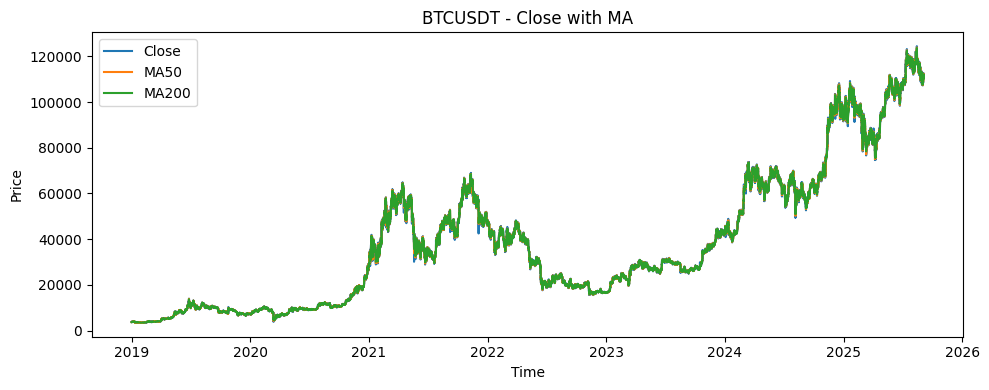

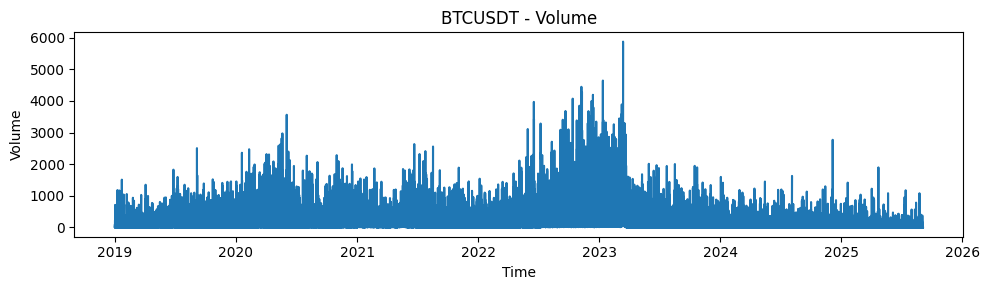

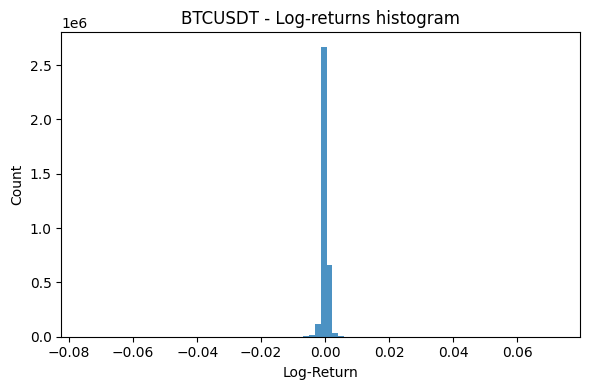

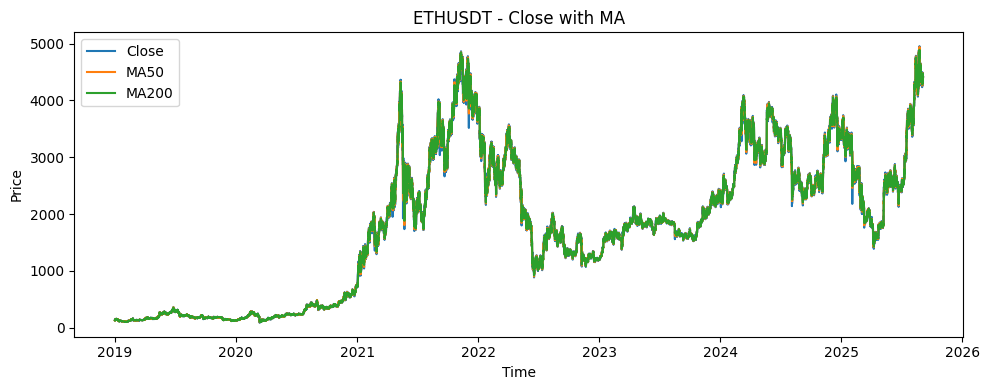

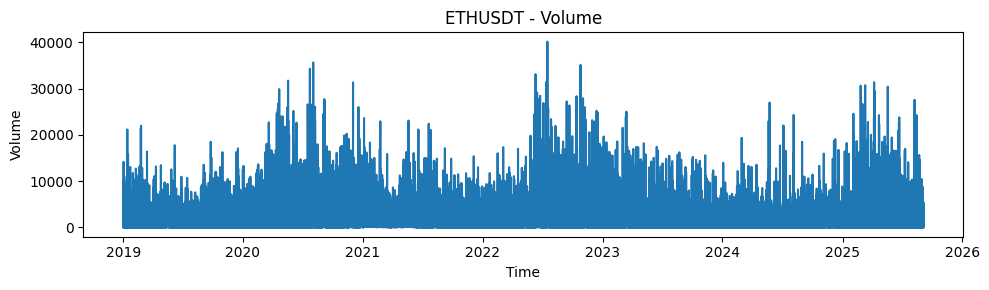

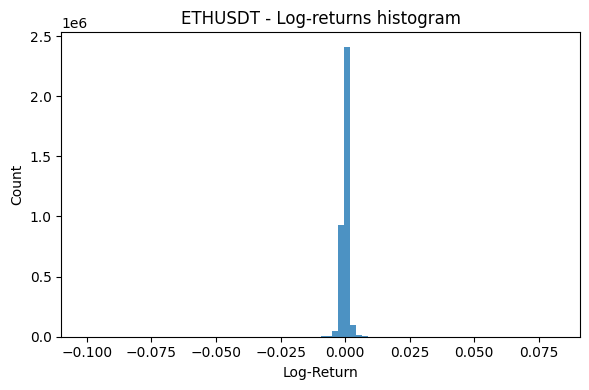

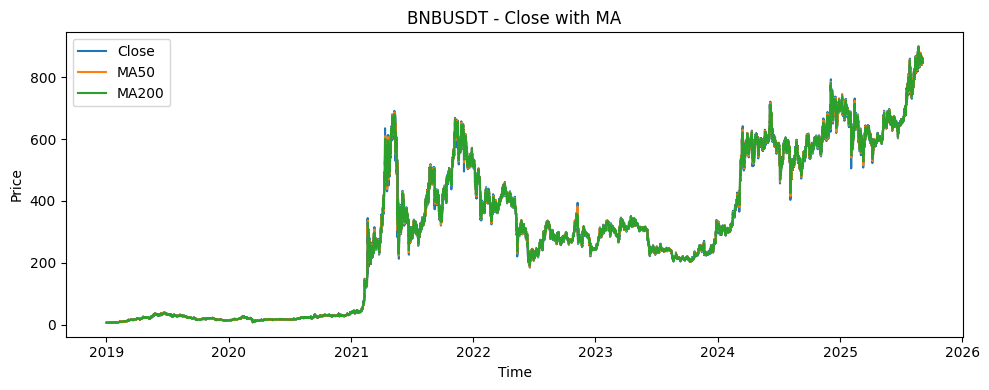

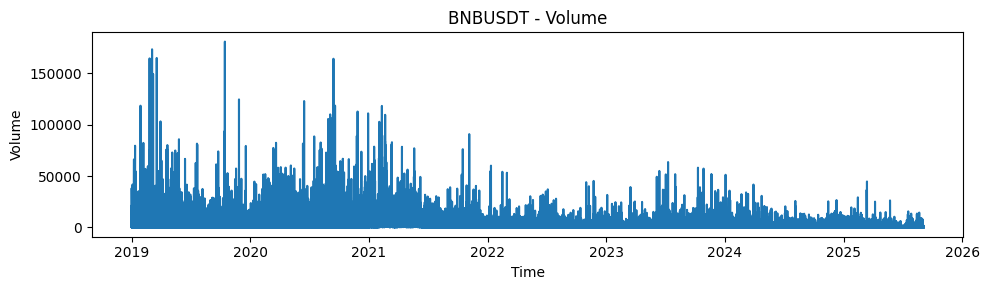

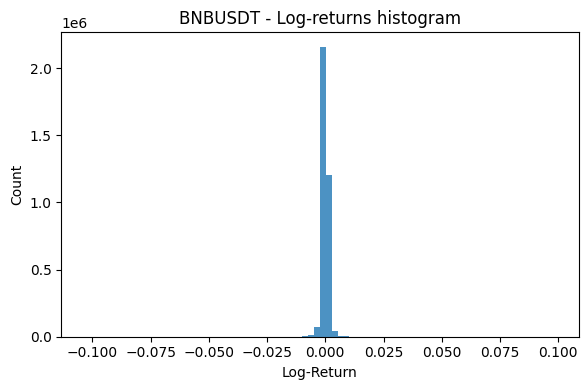

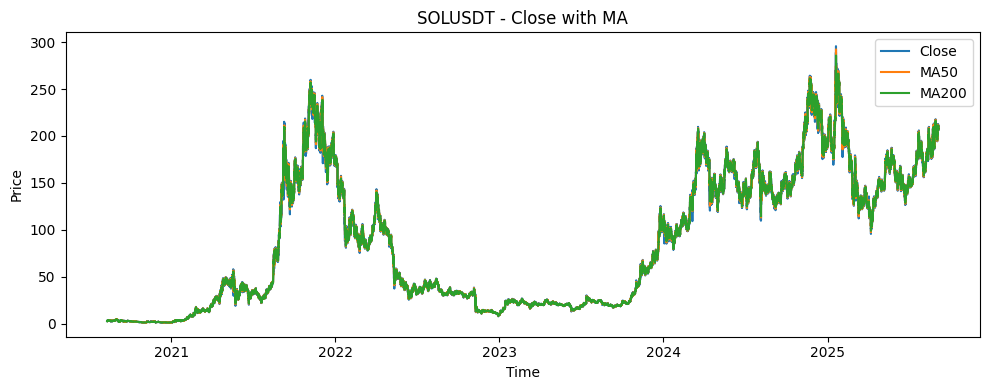

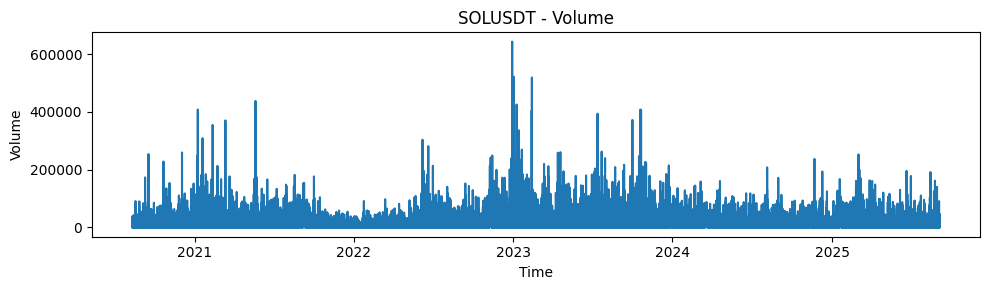

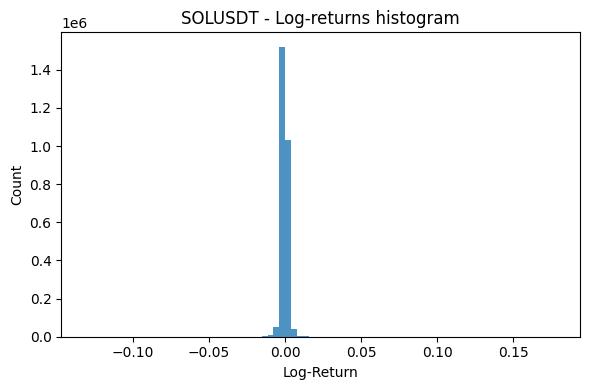

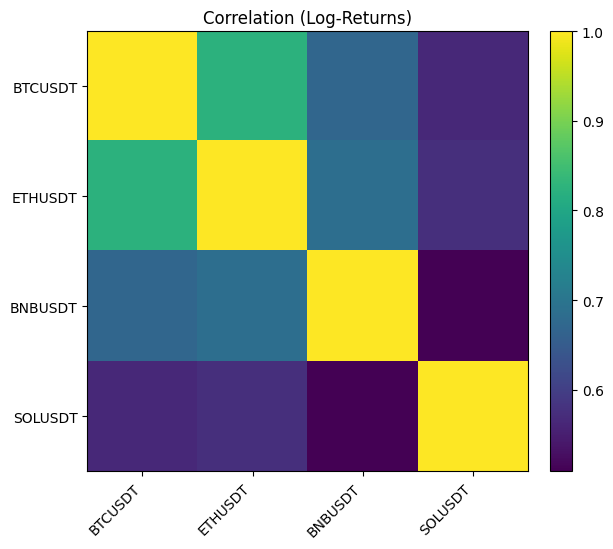

In [7]:

# Price with moving averages, Volume, and Log-return histogram per symbol
for sym, obj in store.items():
    df_en = obj["df_en"]
    cio.plot_price_with_ma(df_en, sym, save=SAVE_PLOTS)
    cio.plot_volume(df_en, sym, save=SAVE_PLOTS)
    cio.plot_logret_hist(df_en, sym, save=SAVE_PLOTS)

# Cross-symbol correlation heatmap on log-returns
cio.plot_corr_heatmap({k: v["df_en"] for k, v in store.items()}, save=SAVE_PLOTS)



### (Optional) Quick look at taker-buy ratio
If you want to eyeball periods with **aggressive buying** vs **aggressive selling**, the `TakerBuyRatio`
(`TakerBuyBase / Volume`) can be useful.


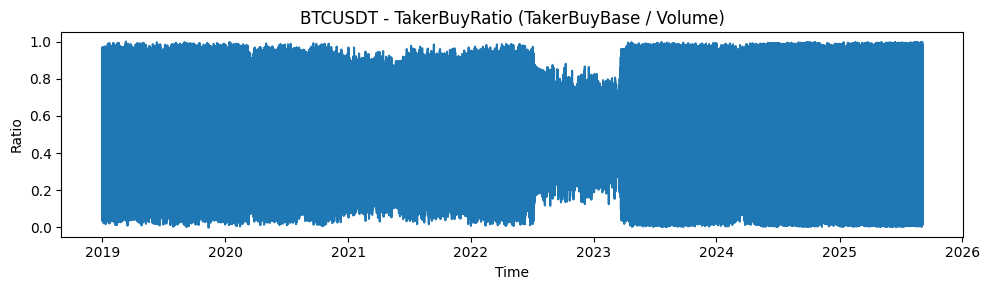

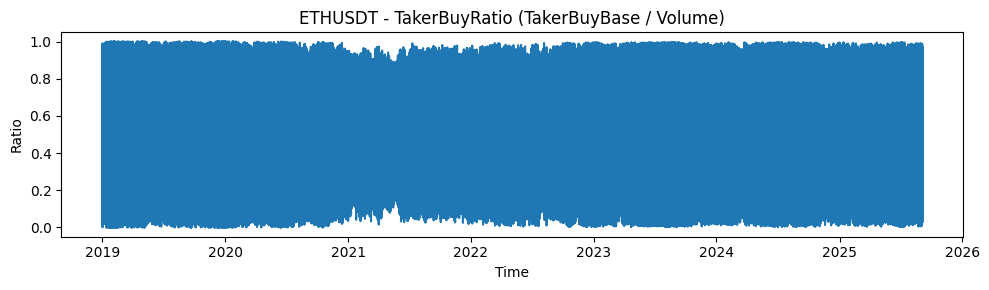

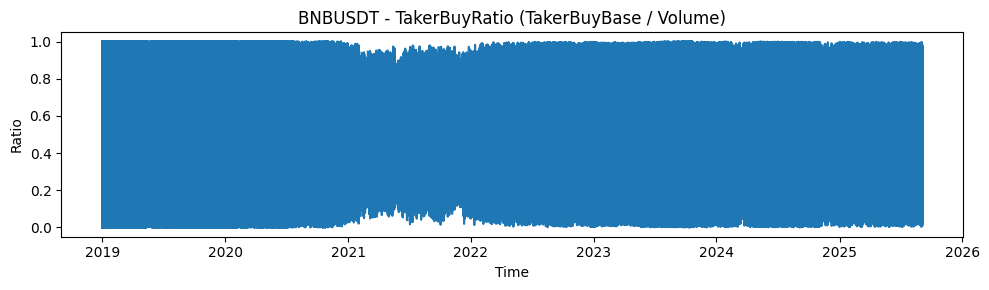

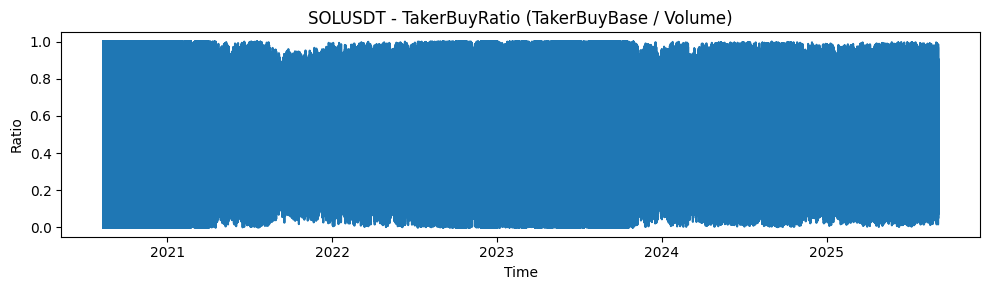

In [8]:

import matplotlib.pyplot as plt

for sym, obj in store.items():
    df_en = obj["df_en"]
    if "TakerBuyRatio" in df_en.columns:
        plt.figure(figsize=(10, 3))
        plt.plot(df_en["open_time"], df_en["TakerBuyRatio"])
        plt.title(f"{sym} - TakerBuyRatio (TakerBuyBase / Volume)")
        plt.xlabel("Time"); plt.ylabel("Ratio")
        plt.tight_layout()
        if SAVE_PLOTS:
            os.makedirs(OUT_DIR, exist_ok=True)
            plt.savefig(os.path.join(OUT_DIR, f"{sym}_takerbuy_ratio.png"), dpi=150)
        plt.show()
